- [8.1.1 Regression Trees](#8.1.1-Regression-Trees)
- [8.1.2 Classification Trees](#8.1.2-Classification-Trees)
- [Lab: 8.3.1 Fitting Classification Trees](#8.3.1-Fitting-Classification-Trees)
- [Lab: 8.3.2 Fitting Regression Trees](#8.3.2-Fitting-Regression-Trees)
- [Lab: 8.3.3 Bagging and Random Forests](#8.3.3-Bagging-and-Random-Forests)
- [Lab: 8.3.4 Boosting](#8.3.4-Boosting)

# Chapter 8 - Tree-based Methods

In [52]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import graphviz

import pydot
from IPython.display import Image

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# from sklearn.externals.six import StringIO  
from six import StringIO
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error

pd.set_option('display.notebook_repr_html', False)

%matplotlib inline
plt.style.use('seaborn-white')

In [53]:
# This function creates images of tree models using pydot
# We did not use it
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return(graph)

### 8.1.1 Regression Trees

In R, I exported the dataset from package 'ISLR' to a csv file.

In [54]:
df = pd.read_csv('Data/Hitters.csv').dropna()
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  263 non-null    object 
 1   AtBat       263 non-null    int64  
 2   Hits        263 non-null    int64  
 3   HmRun       263 non-null    int64  
 4   Runs        263 non-null    int64  
 5   RBI         263 non-null    int64  
 6   Walks       263 non-null    int64  
 7   Years       263 non-null    int64  
 8   CAtBat      263 non-null    int64  
 9   CHits       263 non-null    int64  
 10  CHmRun      263 non-null    int64  
 11  CRuns       263 non-null    int64  
 12  CRBI        263 non-null    int64  
 13  CWalks      263 non-null    int64  
 14  League      263 non-null    object 
 15  Division    263 non-null    object 
 16  PutOuts     263 non-null    int64  
 17  Assists     263 non-null    int64  
 18  Errors      263 non-null    int64  
 19  Salary      263 non-null    f

      Unnamed: 0  AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  \
1    -Alan Ashby    315    81      7    24   38     39     14    3449    835   
2   -Alvin Davis    479   130     18    66   72     76      3    1624    457   
3  -Andre Dawson    496   141     20    65   78     37     11    5628   1575   

   ...  CRuns  CRBI  CWalks  League Division PutOuts  Assists  Errors  Salary  \
1  ...    321   414     375       N        W     632       43      10   475.0   
2  ...    224   266     263       A        W     880       82      14   480.0   
3  ...    828   838     354       N        E     200       11       3   500.0   

   NewLeague  
1          N  
2          A  
3          N  

[3 rows x 21 columns]

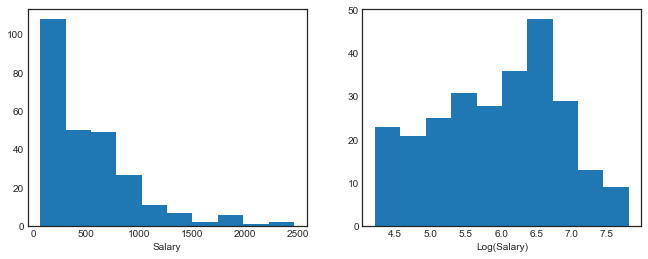

In [55]:
X = df[['Years', 'Hits']]
y = np.log(df.Salary)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,4))
ax1.hist(df.Salary)
ax1.set_xlabel('Salary')  # So Salary is heavily biased toward low part
ax2.hist(y)
ax2.set_xlabel('Log(Salary)'); # Log(Salary) has a more balanced distribution

In [56]:
regr = DecisionTreeRegressor(max_leaf_nodes=3)
regr.fit(X, y)

DecisionTreeRegressor(max_leaf_nodes=3)

### Figure 8.1

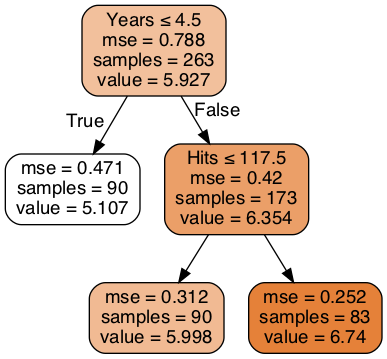

In [57]:
# use sklearn's export to generate the dot-data string file with all the nodes and their props.
dot_data = export_graphviz(regr, out_file='hitters_tree1.dot',feature_names=['Years','Hits'],
                           filled=True, rounded=True,  
                        special_characters=True)

with open('hitters_tree1.dot') as f:
    dot_graph = f.read()  

# create the source object
I = graphviz.Source(dot_graph, format='png', engine='dot')
# Use ipython Image to shrink the rendered image of the source obj to fit into jupyter nb.
Image(I.render())

###  Figure 8.2

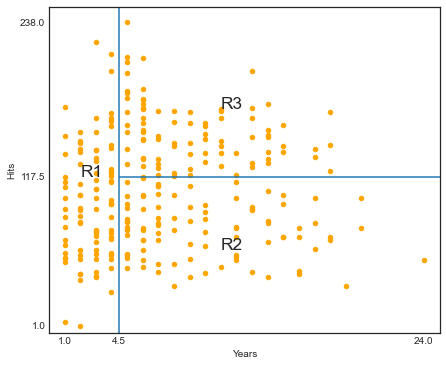

In [58]:
df.plot('Years', 'Hits', kind='scatter', color='orange', figsize=(7,6))
plt.xlim(0,25)
plt.ylim(ymin=-5)
plt.xticks([1, 4.5, 24])
plt.yticks([1, 117.5, 238])
plt.vlines(4.5, ymin=-5, ymax=250)
plt.hlines(117.5, xmin=4.5, xmax=25)
plt.annotate('R1', xy=(2,117.5), fontsize='xx-large')
plt.annotate('R2', xy=(11,60), fontsize='xx-large')
plt.annotate('R3', xy=(11,170), fontsize='xx-large');


### Pruning
Pruning for a classification Tree involves selecting a set of subtrees as a function of a penalization factor $\alpha $ according to the equation 
$$\sum_{m=1}^{|T|}\sum_{i: x_i \in R_m}(y_i-\hat{y})^2+\alpha|T|$$ 
and then using CV to find the optimal subtree.     

#### Using CV to find the optimal tree pruning

In [59]:
regr = DecisionTreeRegressor(max_leaf_nodes=15, random_state=0)
tuned_parameters = {'ccp_alpha': np.logspace(-4, 1, 50)}

In [60]:
# search the parameter space with cross-validation
n_folds = 5
regressor = GridSearchCV(regr, tuned_parameters, cv=n_folds, scoring='neg_mean_squared_error')
regressor.fit(X, y)

GridSearchCV(cv=5,
             estimator=DecisionTreeRegressor(max_leaf_nodes=15, random_state=0),
             param_grid={'ccp_alpha': array([1.00000000e-04, 1.26485522e-04, 1.59985872e-04, 2.02358965e-04,
       2.55954792e-04, 3.23745754e-04, 4.09491506e-04, 5.17947468e-04,
       6.55128557e-04, 8.28642773e-04, 1.04811313e-03, 1.32571137e-03,
       1.67683294e-03, 2.12095089e-03, 2.68269580e-03, 3.39322177...
       7.19685673e-02, 9.10298178e-02, 1.15139540e-01, 1.45634848e-01,
       1.84206997e-01, 2.32995181e-01, 2.94705170e-01, 3.72759372e-01,
       4.71486636e-01, 5.96362332e-01, 7.54312006e-01, 9.54095476e-01,
       1.20679264e+00, 1.52641797e+00, 1.93069773e+00, 2.44205309e+00,
       3.08884360e+00, 3.90693994e+00, 4.94171336e+00, 6.25055193e+00,
       7.90604321e+00, 1.00000000e+01])},
             scoring='neg_mean_squared_error')

In [61]:
cv_result = pd.DataFrame(regressor.cv_results_)
cv_result.sort_values('mean_test_score', ascending=False)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
22       0.002125      0.000106         0.001352        0.000014   
21       0.002027      0.000014         0.001342        0.000038   
19       0.002138      0.000117         0.001371        0.000029   
25       0.002023      0.000018         0.001342        0.000059   
24       0.002007      0.000005         0.001321        0.000004   
23       0.002038      0.000039         0.001330        0.000011   
20       0.002155      0.000087         0.001422        0.000053   
17       0.002106      0.000046         0.001436        0.000112   
16       0.002097      0.000101         0.001498        0.000229   
13       0.002037      0.000035         0.001328        0.000006   
1        0.002717      0.000531         0.001741        0.000204   
14       0.002018      0.000005         0.001323        0.000020   
0        0.003061      0.000354         0.001826        0.000171   
12       0.002014      0.000005         0.001323

In [62]:
# Choose the best CV parameters
regressor.best_params_

{'ccp_alpha': 0.01757510624854793}

In [63]:
# The estimator at the CV best model
best_regr = regressor.best_estimator_

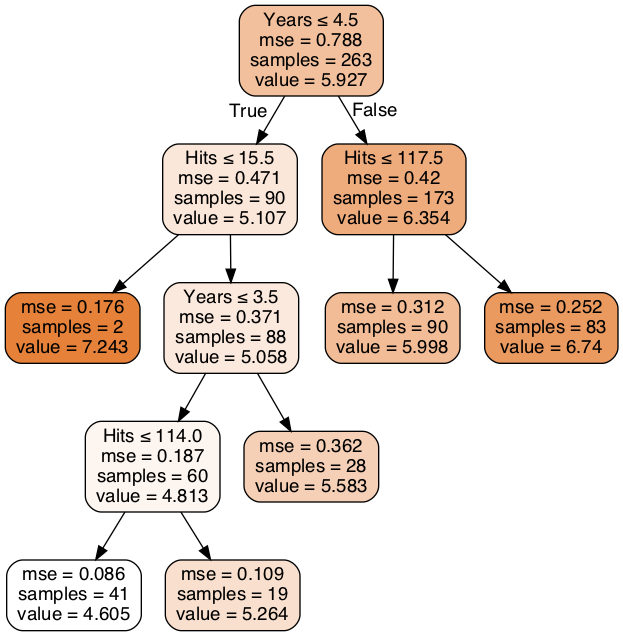

In [64]:
# use sklearn's export to generate the dot-data string file with all the nodes and their props.
dot_data = export_graphviz(best_regr, out_file='hitters_tree1.dot',feature_names=['Years','Hits'],
                           filled=True, rounded=True,  
                        special_characters=True)

with open('hitters_tree1.dot') as f:
    dot_graph = f.read()  

# create the source object
I = graphviz.Source(dot_graph, format='png', engine='dot')
# Use ipython Image to shrink the rendered image of the source obj to fit into jupyter nb.
Image(I.render())

#### Analysis 1: impurity of leaves against regularization parameter ccp_alpha

In [65]:
regr = DecisionTreeRegressor(random_state=0)
# Compute the pruning path during Minimal Cost-Complexity Pruning.
path = regr.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

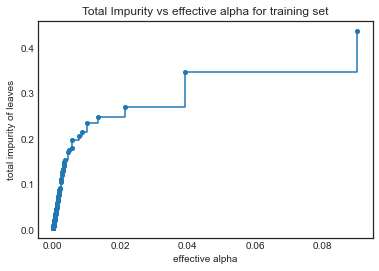

In [66]:
# in the following plot, the maximum effective alpha value is removed, 
# because it is the trivial tree with only one node.
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post", markersize=4)
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

#### Analysis 2: Number of nodes and depth against regularization parameter ccp_alpha

In [67]:
# Next, we train a decision tree using the effective alphas. 
# The last value in ccp_alphas is the alpha value that prunes the whole tree, l
# eaving the tree, regrs[-1], with one node.

regrs = []
for ccp_alpha in ccp_alphas:
    regr = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    regr.fit(X, y)
    regrs.append(regr)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      regrs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.35017208341149475


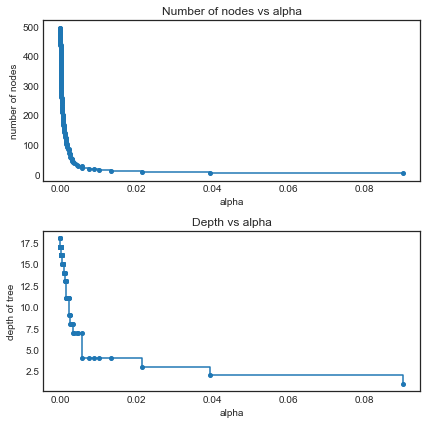

In [68]:
# For the remainder of this example, we remove the last element in regrs and ccp_alphas, 
# because it is the trivial tree with only one node. 
# Here we show that the number of nodes and tree depth decreases as alpha increases.

regrs = regrs[:-1]
ccp_alphas_ = ccp_alphas[:-1]

node_counts = [regr.tree_.node_count for regr in regrs]
depth = [regr.tree_.max_depth for regr in regrs]
fig, ax = plt.subplots(2, 1, figsize=(6,6))
ax[0].plot(ccp_alphas_, node_counts, marker='o', drawstyle="steps-post", markersize=4)
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas_, depth, marker='o', drawstyle="steps-post", markersize=4)
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

#### Analysis 3: Training and testing loss against regularization parameter ccp_alpha

In [118]:
# we need to split training/testing set first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0, shuffle=True)

In [119]:
# We recompute the pruning path since we are using new dataset (X_train, y_train) for training
regr = DecisionTreeRegressor(random_state=0)
# Compute the pruning path during Minimal Cost-Complexity Pruning.
path = regr.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [120]:
regrs = []
for ccp_alpha in ccp_alphas:
    regr = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    regr.fit(X_train, y_train)
    regrs.append(regr)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      regrs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.28289736189930026


In [121]:
def rmse(y_pred, y):
    # root mean square error
    return np.sqrt(np.mean((y-y_pred)**2))

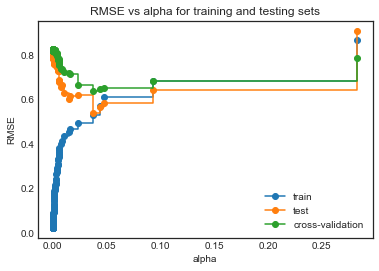

In [122]:
# As alpha increases, more of the tree is pruned, thus creating a decision tree that generalizes better. 
train_scores = [rmse(regr.predict(X_train), y_train) for regr in regrs]
cv_scores = [-cross_val_score(regr, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean() for regr in regrs]
test_scores = [rmse(regr.predict(X_test), y_test) for regr in regrs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("RMSE")
ax.set_title("RMSE vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.plot(ccp_alphas, cv_scores, marker='o', label="cross-validation",
        drawstyle="steps-post")
ax.legend()
plt.show()

### 8.1.2 Classification Trees

Dataset available on https://www.statlearning.com/resources-first-edition

In [214]:
df2 = pd.read_csv('Data/Heart.csv').drop('Unnamed: 0', axis=1).dropna()
df2.info()
df2.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        297 non-null    int64  
 1   Sex        297 non-null    int64  
 2   ChestPain  297 non-null    object 
 3   RestBP     297 non-null    int64  
 4   Chol       297 non-null    int64  
 5   Fbs        297 non-null    int64  
 6   RestECG    297 non-null    int64  
 7   MaxHR      297 non-null    int64  
 8   ExAng      297 non-null    int64  
 9   Oldpeak    297 non-null    float64
 10  Slope      297 non-null    int64  
 11  Ca         297 non-null    float64
 12  Thal       297 non-null    object 
 13  AHD        297 non-null    object 
dtypes: float64(2), int64(9), object(3)
memory usage: 34.8+ KB


   Age  Sex     ChestPain  RestBP  Chol  Fbs  RestECG  MaxHR  ExAng  Oldpeak  \
0   63    1       typical     145   233    1        2    150      0      2.3   
1   67    1  asymptomatic     160   286    0        2    108      1      1.5   
2   67    1  asymptomatic     120   229    0        2    129      1      2.6   

   Slope   Ca        Thal  AHD  
0      3  0.0       fixed   No  
1      2  3.0      normal  Yes  
2      2  2.0  reversable  Yes  

In [215]:
df2.ChestPain = pd.factorize(df2.ChestPain)[0]
df2.Thal = pd.factorize(df2.Thal)[0]

In [216]:
X2 = df2.drop('AHD', axis=1)
y2 = pd.factorize(df2.AHD)[0]

In [217]:
clf = DecisionTreeClassifier(max_depth=None, max_leaf_nodes=6, max_features=3)
clf.fit(X2,y2)

DecisionTreeClassifier(max_features=3, max_leaf_nodes=6)

In [218]:
clf.score(X2,y2)

0.7508417508417509

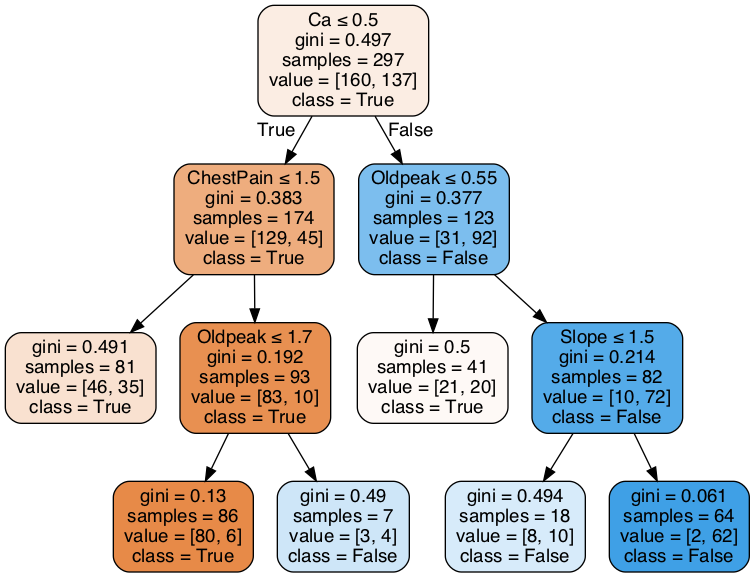

In [219]:
#graph2 = print_tree(clf, features=X2.columns, class_names=['No', 'Yes'])
#Image(graph2.create_png())
# use sklearn's export to generate the dot-data string file with all the nodes and their props.
dot_data = export_graphviz(clf, out_file='heart_tree.dot',feature_names=X2.columns,
                           class_names=['True', 'False'], filled=True, rounded=True,  
                        special_characters=True)

with open('heart_tree.dot') as f:
    dot_graph = f.read()  

# create the source object
I = graphviz.Source(dot_graph, format='png', engine='dot')
# Use ipython Image to shrink the rendered image of the source obj to fit into jupyter nb.
Image(I.render())

## Lab

### 8.3.1 Fitting Classification Trees

In R, I exported the dataset from package 'ISLR' to a csv file.

In [220]:
df3 = pd.read_csv('Data/Carseats.csv')
df3.info()
df3.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    object 
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    object 
 10  US           400 non-null    object 
dtypes: float64(1), int64(7), object(3)
memory usage: 34.5+ KB


   Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0   9.50        138      73           11         276    120       Bad   42   
1  11.22        111      48           16         260     83      Good   65   
2  10.06        113      35           10         269     80    Medium   59   
3   7.40        117     100            4         466     97    Medium   55   
4   4.15        141      64            3         340    128       Bad   38   

   Education Urban   US  
0         17   Yes  Yes  
1         10   Yes  Yes  
2         12   Yes  Yes  
3         14   Yes  Yes  
4         13   Yes   No  

In [221]:
# create a new column called High, a boolean for if sales > 8
df3['High'] = df3.Sales > 8
df3 = pd.get_dummies(df3, columns=['ShelveLoc', 'Urban', 'US'])
# drop the unnecessary columns -- remember the number of dummies is always one less than the number of levels
#df3 = df3.drop(['ShelveLoc_Bad', 'Urban_No', 'US_No'],axis=1)


# Another way to do this:
#df3['High'] = df3.Sales.map(lambda x: 1 if x>8 else 0)
#df3.ShelveLoc = pd.factorize(df3.ShelveLoc)[0]
# df3.Urban = df3.Urban.map({'No':0, 'Yes':1})
# df3.US = df3.US.map({'No':0, 'Yes':1})
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Sales             400 non-null    float64
 1   CompPrice         400 non-null    int64  
 2   Income            400 non-null    int64  
 3   Advertising       400 non-null    int64  
 4   Population        400 non-null    int64  
 5   Price             400 non-null    int64  
 6   Age               400 non-null    int64  
 7   Education         400 non-null    int64  
 8   High              400 non-null    bool   
 9   ShelveLoc_Bad     400 non-null    uint8  
 10  ShelveLoc_Good    400 non-null    uint8  
 11  ShelveLoc_Medium  400 non-null    uint8  
 12  Urban_No          400 non-null    uint8  
 13  Urban_Yes         400 non-null    uint8  
 14  US_No             400 non-null    uint8  
 15  US_Yes            400 non-null    uint8  
dtypes: bool(1), float64(1), int64(7), uint8(7)
m

In [222]:
df3.head(5)

   Sales  CompPrice  Income  Advertising  Population  Price  Age  Education  \
0   9.50        138      73           11         276    120   42         17   
1  11.22        111      48           16         260     83   65         10   
2  10.06        113      35           10         269     80   59         12   
3   7.40        117     100            4         466     97   55         14   
4   4.15        141      64            3         340    128   38         13   

    High  ShelveLoc_Bad  ShelveLoc_Good  ShelveLoc_Medium  Urban_No  \
0   True              1               0                 0         0   
1   True              0               1                 0         0   
2   True              0               0                 1         0   
3  False              0               0                 1         0   
4  False              1               0                 0         0   

   Urban_Yes  US_No  US_Yes  
0          1      0       1  
1          1      0       1  
2       

In [223]:
X = df3.drop(['Sales', 'High'], axis=1)
y = df3.High

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=0)

In [224]:
clf = DecisionTreeClassifier(max_depth=6)
clf.fit(X, y)

DecisionTreeClassifier(max_depth=6)

In [225]:
print(classification_report(y, clf.predict(X)))

              precision    recall  f1-score   support

       False       0.88      1.00      0.94       236
        True       0.99      0.81      0.89       164

    accuracy                           0.92       400
   macro avg       0.94      0.90      0.91       400
weighted avg       0.93      0.92      0.92       400



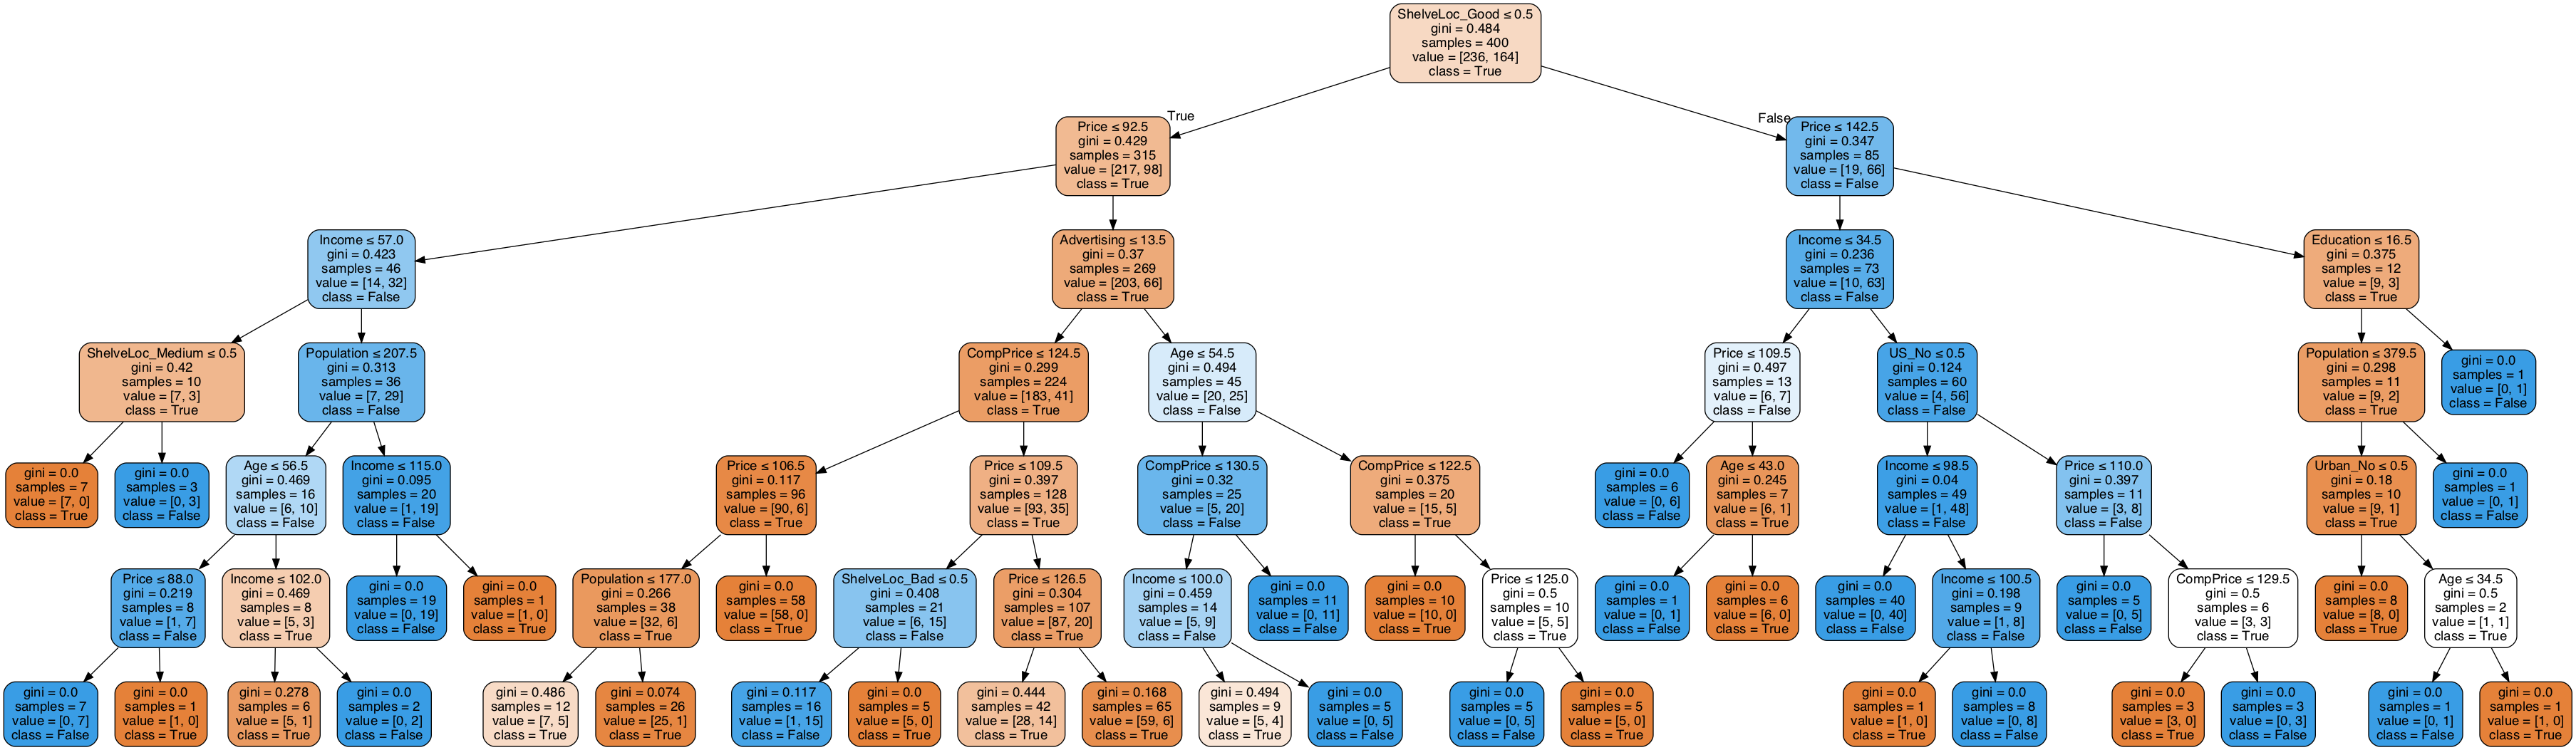

In [226]:
# use sklearn's export to generate the dot-data string file with all the nodes and their props.
dot_data = export_graphviz(clf, out_file='seat_tree.dot',feature_names=X_train.columns, 
                class_names=['True', 'False'],filled=True, rounded=True,  
                        special_characters=True)

with open('seat_tree.dot') as f:
    dot_graph = f.read()  

# create the source object
I = graphviz.Source(dot_graph, format='png', engine='dot')
# Use ipython Image to shrink the rendered image of the source obj to fit into jupyter nb.
Image(I.render())

In [227]:
# also show the view of the source object in browser so we can zoom in on nodes and see what we've got
I.view()

'Source.gv.png'

In [228]:
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [229]:
cm = pd.DataFrame(confusion_matrix(y_test, pred).T, index=['No', 'Yes'], columns=['No', 'Yes'])
cm.index.name = 'Predicted'
cm.columns.name = 'True'
cm

True       No  Yes
Predicted         
No         99   28
Yes        19   54

In [230]:
# Precision of the model using test data is 74%
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.78      0.84      0.81       118
        True       0.74      0.66      0.70        82

    accuracy                           0.77       200
   macro avg       0.76      0.75      0.75       200
weighted avg       0.76      0.77      0.76       200



Pruning not implemented in scikit-learn.

### 8.3.2 Fitting Regression Trees

In R, I exported the dataset from package 'MASS' to a csv file.

In [231]:
boston_df = pd.read_csv('Data/Boston.csv')
boston_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  black    506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [232]:
X = boston_df.drop('medv', axis=1)
y = boston_df.medv

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=0)

In [233]:
# Pruning not supported. Choosing max depth 3)
regr2 = DecisionTreeRegressor(max_depth=3)
regr2.fit(X_train, y_train)
pred = regr2.predict(X_test)

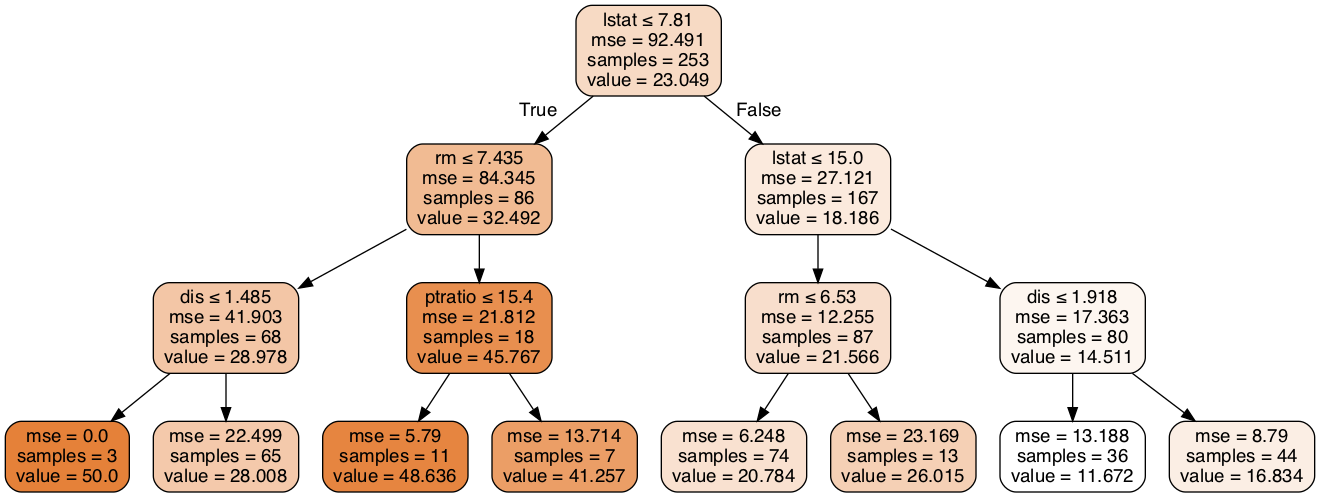

In [234]:
# use sklearn's export to generate the dot-data string file with all the nodes and their props.
dot_data = export_graphviz(regr2, out_file='boston_tree.dot',feature_names=X_train.columns,
                           filled=True, rounded=True, special_characters=True)

with open('boston_tree.dot') as f:
    dot_graph = f.read()  

# create the source object
I = graphviz.Source(dot_graph, format='png', engine='dot')
# Use ipython Image to shrink the rendered image of the source obj to fit into jupyter nb.
Image(I.render())

For suburbs with lstat < 7.81 and rm > 7.44 the tree predicts a median home value of $45,766; a value that is very close to the labs value of 46,400.

Text(0, 0.5, 'y_test')

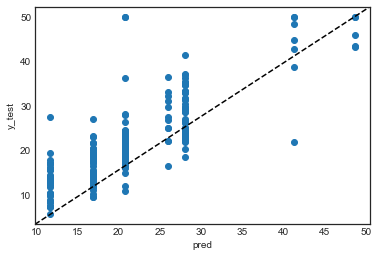

In [235]:
plt.scatter(pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')

In [236]:
mean_squared_error(y_test, pred)

26.023230850097445

### 8.3.3 Bagging and Random Forests

In [237]:
# There are 13 features in the dataset
X.shape

(506, 13)

In [238]:
# Bagging: using all features
regr1 = RandomForestRegressor(max_features=13, random_state=1)
regr1.fit(X_train, y_train)

RandomForestRegressor(max_features=13, random_state=1)

Text(0, 0.5, 'y_test')

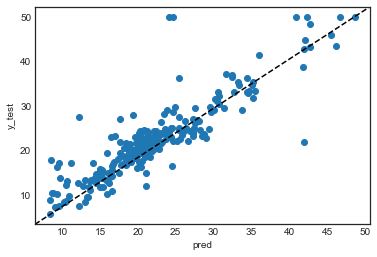

In [239]:
pred = regr1.predict(X_test)

plt.scatter(pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')

In [240]:
mean_squared_error(y_test, pred)

16.17512869960475

In [241]:
# Random forests: using 6 features
regr2 = RandomForestRegressor(max_features=6, random_state=1)
regr2.fit(X_train, y_train)

RandomForestRegressor(max_features=6, random_state=1)

In [242]:
pred = regr2.predict(X_test)
mean_squared_error(y_test, pred)

15.82350045849802

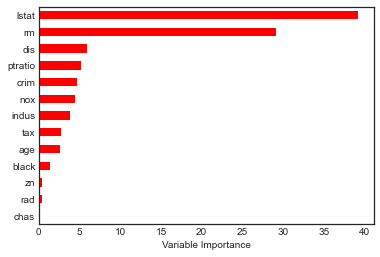

In [243]:
Importance = pd.DataFrame({'Importance':regr2.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

### 8.3.4 Boosting

In [244]:
regr = GradientBoostingRegressor(n_estimators=500, learning_rate=0.01, random_state=1)
regr.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, n_estimators=500, random_state=1)

lstat      54.922618
rm         27.934202
dis         5.896297
ptratio     4.370389
crim        2.799589
tax         1.098078
age         0.922677
nox         0.731767
indus       0.576559
black       0.460309
rad         0.153199
chas        0.121257
zn          0.013059
dtype: float64
13


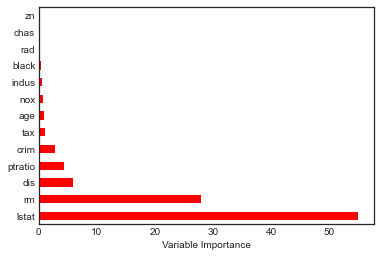

In [245]:
#feature_importance = regr.feature_importances_*100


feature_importance = pd.Series(data=regr.feature_importances_*100, index=list(X.columns))
rel_imp = feature_importance.sort_values(ascending=False) #(inplace=False)
print(rel_imp)
print(len(rel_imp))
rel_imp.T.plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [246]:
mean_squared_error(y_test, regr.predict(X_test))

15.592155779633027

### Partial Dependence Plot
One of the advantages of parametric statistical learning methods such as linear regression is that we can easily interpret the effect of a single predictor on the model by examing each covariates coeffecients. With boosted decision trees interpreting a model can be difficult. One method is to consider partial dependence plots.

A partial dependence plot examines the effect of single predictor after averaging out the effect of all other predictors. Please see https://cran.r-project.org/web/packages/datarobot/vignettes/PartialDependence.html. Briefly recall that our estimate for the response y can be written as ${\hat{y}}_k = F(x_{1k}, x_{2k},...x_{pk}$ where k is the number of observations and p is the covariate number. Now lets suppose that we average all the ${\hat{y}}_k$ except for one covariate which we leave free to vary. We can write this as $\phi_j(x) = \frac{1}{N} \sum_{k=1}^{N} F(x_{1,k}, x_{2,k},...x_{j-1,k},x, x_{j+1,k},...x_{p,k})$. This is equivalent to writing $\phi_j(x) = \frac{1}{N}(\hat{y}_1 + \hat{y}_2 + ... y_j(x) + .... \hat{y}_p)$. So what $\phi_j(x)$ represents is the effect of the jth covariate after averaging out the effects from all the other covariates. Note there is a drawback in that it will miss interaction effects. Sklearn provides the functionality we require to make a plot of $\phi_j(x)$.

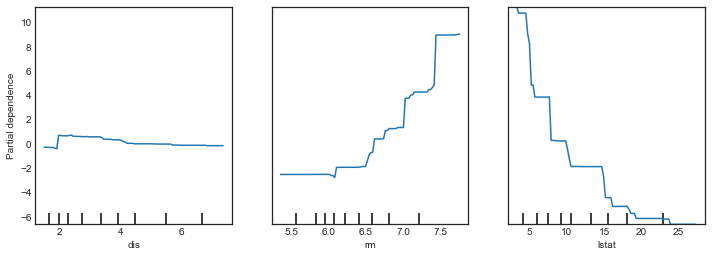

In [247]:
# Get the three feature indexes with the highest importance (lstat, rm, dis)
feature_idxs=np.argsort(feature_importance.values)[-3:]
# Create the PDP
fig, axs = plt.subplots(1,1, figsize=(12,4))
plot_partial_dependence(regr, X_train, features=feature_idxs, 
                                    feature_names=feature_importance.index.tolist(), ax=axs);

This plots make sense with what we know about this dataset from previous labs. Increasing number of rooms increases the medv and decreasing lstat ( a poverty measure) increases medv.